![Image of Yaktocat](https://cdn.mos.cms.futurecdn.net/rLh7Dh7EKo8F6zmDtXYp8W.jpg)
# Table of Contents
1. [Introduction](#introduction)
2. [Install packages](#install-pkg)
3. [Data Dowloading](#data-download)
4. [Preprocessing](#preprocessing)<br>
    a. [Load and Clean Dataset](#load-and-clean)<br>
    b. [Data Analysis and Visualization](#data-ana-vis)
5. [Machine Learning Model](#ml-model)<br>
    a. [What and Why](#what-why)<br>
    b. [Training](#training)<br>
    c. [Result Anlysis and Demonstration](#result-ana-demon)
6. [Future Application](#future-app)
7. [Reference and External Link](#ref-and-extlink)

## 1. Introduction <a name="introduction"></a>
Have you ever dreamed about strolling around a dystopian metropole where violence, oppression, and cyberware implants are just common in 2077?
Have you ever dreamed about swinging a Great Sword fight against a giant ancient dragon in Monster World?
Have you ever dreamed about driving Bugatti Veyron Super Sport in the city while all your opponents are in your rear mirror?
Playing video games is becoming a more and more popular option for people to entertain themselves, especially during this hard time of COVID-19.
The value of the global gaming market almost doubled from 2012 to 2020. Now, it is a 150-billion-dollar industry with over ten thousand of games developed and published each year.
As we are interested in what makes a game popular, we will use data science techniques to explore and analyze the video game sales data, 

## 2. Install Packages <a name="install-pkg"></a>
```
pip install kaggle numpy matplotlib pandas sklearn
```
or use [environment.yml](https://github.com/syKevinPeng/game_sale_analysis/blob/main/environment.yml) to install packages in Conda environment
```
conda env update -f environment.yml
```
## 3. Data Downloading <a name="data-download"></a>

In [9]:
import kaggle
# remember to put kaggle.json to your C:/username/.kaggle
!kaggle datasets download -d ashaheedq/video-games-sales-2019

video-games-sales-2019.zip: Skipping, found more recently modified local copy (use --force to force download)


or directly download from kaggle webpage: [https://www.kaggle.com/ashaheedq/video-games-sales-2019](https://www.kaggle.com/ashaheedq/video-games-sales-2019)_
## 4. Preprocessing <a name="preprocessing"></a>
In this section, we will load and process the two datasets: "vgsales-12-4-2019.csv" is our main dataset and "video_games.csv"
is a complementary dataset we will use to fill in  important missing values like "Global_Sales" and "Critic_Score" in the first dataset.
**Datasets**

"vgsales-12-4-2019.csv" is a kaggle dataset with around 50000 records of game sales collected in 2019.
There are missing values in the column "Global_Sales", since this column is the predicted value for our model training,
we load another dataset "video_games.csv" to fill in these values as many as possible and drop the rest N/A values.

"video_games.csv" is a dataset of Steam game sales,
 we load it from [this repository](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-07-30).
 It has a cloumn "owners" which includes a range of the number of players that own each game,
 we take the expected value (or median) of every range as the replacement for the missing data in the first dataset,
 and we will do the same for the missing values in "Critic_Score". To merge the two datasets after doing necessary
 processing, we will use a LEFT JOIN based on the columns "Name" and "Year".
### 4.a. Load and Clean Data <a name="load-and-clean"></a>
In the following cells we import the libraries,load the datasets using pandas.read_csv() function, and reate a preview of the datasets using df.head() function.

In [10]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
import locale

locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
df = pd.read_csv("vgsales-12-4-2019.csv")
additional = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-30/video_games.csv")

**A preview of the main dataset**
<img src="images/df1.png">

**A preview of the additional dataset**
<img src="images/df2.png">

**Clean the additional dataset**

Let's process the additional dataset. First, we drop rows with NaN values in the columns "owners" and "release_date"
because we do not want to have missing values in these columns, and reset the index of the dataframe. Next, we divide
the values in the column "metascore" by 10 to make the unit (a float with one decimal place) match in both tables, and
store the results in a new column "Critic_Score". To calculate the median of the range of owners, we convert the values
in the column "owners" to string, then iterate through the dataframe to split the string and convert the results to integers,
finally we calculate the result (in millions). In the same loop, we also extract the value of year from the column "release_date".
 Note that there are NaN values in the column "Critic_Score" but we do not drop them because our main goal is to get more values
 for "Global_Sales". After renaming the columns that we will use to merge the datasets
 (by copying to new columns and dropping the original columns), we finish processing the additional dataset.

In [11]:
additional = additional.dropna(subset = ['owners', 'release_date'])
additional = additional.reset_index(drop = True)
additional['Critic_Score'] = additional['metascore']/10
additional['Year'] = additional['release_date']
additional['owners'] = additional['owners'].astype(str)
# calculate median of owners and extract value of year
for i in range(len(additional)):
    str(additional.loc[i, 'owners'])
    nums = additional.loc[i, 'owners'].split('\xa0..\xa0')
    additional.loc[i, 'owners'] = float((locale.atoi(nums[1]) - locale.atoi(nums[0])) / 2000000)
    temp = additional.loc[i, 'Year'].split(', ')
    if len(temp) != 2:
        additional.loc[i, 'Year'] = np.nan
    else:
        additional.loc[i, 'Year'] = int(temp[1])

additional = additional.dropna(subset = ['release_date'])
# drop useless columns and rename columns
additional = additional.drop(columns = ['number', 'price', 'average_playtime', 'median_playtime'])
additional['Name'] = additional['game']
additional['Developer'] = additional['developer']
additional['Global_Sales'] = additional['owners']
additional = additional.drop(columns=['metascore', 'release_date', 'publisher', 'game', 'developer', 'owners'])

**A preview of the processed additional dataset**
<img src="images/df3.png" style="width: 600px;">

**Merge the main dataset and the additional dataset**

Before merging the two datasets, we drop rows having missing values in the column "Year" as we will use this column
and the column "Name" in merging. Then we drop columns we will not use in data visualization and data analysis, which
are 'Rank', 'basename', 'Total_Shipped', 'Platform', 'Publisher', 'VGChartz_Score', 'Last_Update', 'url', 'status',
'Vgchartzscore', 'img_url', 'User_Score'.

The type of join we choose is left join, because we do not want to add excessive records from the additional dataset.

In [12]:
df = df.dropna(subset = ['Year'])
df['Year'] = df['Year'].astype(int)
df = df.drop(columns=['Rank', 'basename', 'Total_Shipped', 'Platform', 'Publisher', 'VGChartz_Score',
                      'Last_Update', 'url', 'status', 'Vgchartzscore', 'img_url',  'User_Score'])
# left join on 'Name', 'Year'
pd.merge(df, additional, on = ['Name', 'Year'] , how = 'left')
print("")

**A preview of the merged dataset**
<img src="images/df4.png">

**Process the merged dataset**

First we drop rows with missing values in the columns "Developer" and "Genre", and reset the index.
It is obvious to predict sales as numerical data but we have the accuracy concern(we will see accuracy in the **Result Analysis and Demonstration** section)
since the data may not demonstrate a strong linear trend. Therefore, we hope to predict it as categorical data: sale score is divided into 4 categories.
Games in ">10" category are expected to sell so greate that its name will left in history -- Grand Theft Auto, Pokemon, Call of duty and etc. You name it.
Games in "5-10" category are sold less than the top ones, but they are still great games. "5-1" games are good games. there are still large amount of customer want to
put them into their gaming library. The rest of games can be put into "1-0" categories. We respect the efforts that game developers put into them but they are relatively
niche.

For data analysis, we need to convert categorical variable to numerical variable. We choose to use label encoding on
the three categories, "Genre", "ESRB_Rating" and "Developer" because it is easier to process numerical values in data
analysis than processing string values. Since the total number of developers is large and we will use "Genre"
in data visualization, we will process "Developer" and "Genre" later. To create the dataframe for data analysis,
 we need to drop columns that we will not use, which are 'Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'.
  Also, we will normalize the numerical values in the columns "Global_Sales" and "NA_Sales" by using the sklearn.preprocessing module.

In [13]:
df = df.dropna(subset=['Developer', 'Genre'])
df = df.reset_index(drop = True)
df['Sales_Ranking'] = df['Global_Sales']
# get values for the column 'Sales_Ranking'
for i in range(len(df)):
    df.loc[i, 'Developer'] = str(df.loc[i, 'Developer'])
    if df.loc[i, 'Sales_Ranking'] >= 10:
        df.loc[i, 'Sales_Ranking'] = 4
    elif df.loc[i, 'Sales_Ranking'] >= 5 and df.loc[i, 'Sales_Ranking'] < 10:
        df.loc[i, 'Sales_Ranking'] = 3
    elif df.loc[i, 'Sales_Ranking'] >= 1 and df.loc[i, 'Sales_Ranking'] < 5:
        df.loc[i, 'Sales_Ranking'] = 2
    else:
        df.loc[i, 'Sales_Ranking'] = 1

le = LabelEncoder()
# ohe = OneHotEncoder(handle_unknown = 'ignore')
df['Sales_Ranking'] = df['Sales_Ranking'].astype(int)
df = df.dropna(subset=['Global_Sales', 'ESRB_Rating'])
df['ESRB_Rating'] = le.fit_transform(df['ESRB_Rating'])
# df_temp = pd.DataFrame(ohe.fit_transform(df[['Genre']]).toarray())
# df = df.join(df_temp)

**Dataframe for data visualization**

Now we create the dataframe for data visualization. We drop rows with NaN values in the columns "Global_Sales"
and "NA_Sales" because these missing values can not be used in plotting the graphs.

In [14]:
df = df.reset_index(drop = True)
df = df[df['Global_Sales'] != 0.0]
df_for_visualization = df.dropna(subset = ['Global_Sales', 'NA_Sales'])
df_for_visualization = df_for_visualization.reset_index(drop = True)

**A preview of the dataset for visualization**
<img src="images/df5.png">

**Dataframe for data analysis**

To create the dataframe for data analysis, we need to drop columns that we will not use,
which are 'Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'. Also, we will normalize
the numerical values in the columns "Global_Sales" and "NA_Sales" by using the sklearn.preprocessing module.

In [15]:
df_for_training = df.drop(columns = ['Name', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score'])
df_for_training = df_for_training.dropna(subset = ['NA_Sales'])
temp_df = df_for_training.drop(columns=['Genre', 'ESRB_Rating', 'Developer', 'Year', 'Sales_Ranking'])
# create a temp dataframe for normalization of numerical values
x = temp_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
temp_df = pd.DataFrame(x_scaled)
# copy normalized values into the training dataframe
df_for_training['Global_Sales'] = temp_df[0]
df_for_training['NA_Sales'] = temp_df[1]
df_for_training = df_for_training.dropna(subset = ['Global_Sales', 'NA_Sales'])
df_for_training = df_for_training.reset_index(drop = True)
# apply label encoding on 'Genre' and 'Developer'
df_for_training['Genre'] = le.fit_transform(df_for_training['Genre'])
df_for_training['Developer'] = le.fit_transform(df_for_training['Developer'])
# Shuffle and reorder the dataframe
df_for_training = df_for_training.sample(frac=1)[['Genre','ESRB_Rating','Developer','NA_Sales','Year','Global_Sales','Sales_Ranking']]

**A preview of the dataset for visualizarion**
<img src="images/df6.png" style="width: 600px;">

### 4.b Data Analysis and Visualization' <a name="data-ana-vis"></a>
In this section, we will plot processed data and observe the infomation provided by the dataset that can be useful in future analysis.

First, in order to get a general picture of video game sale in recent years, we plot a graph of video game annual sales over year, from 2000 to 2018.

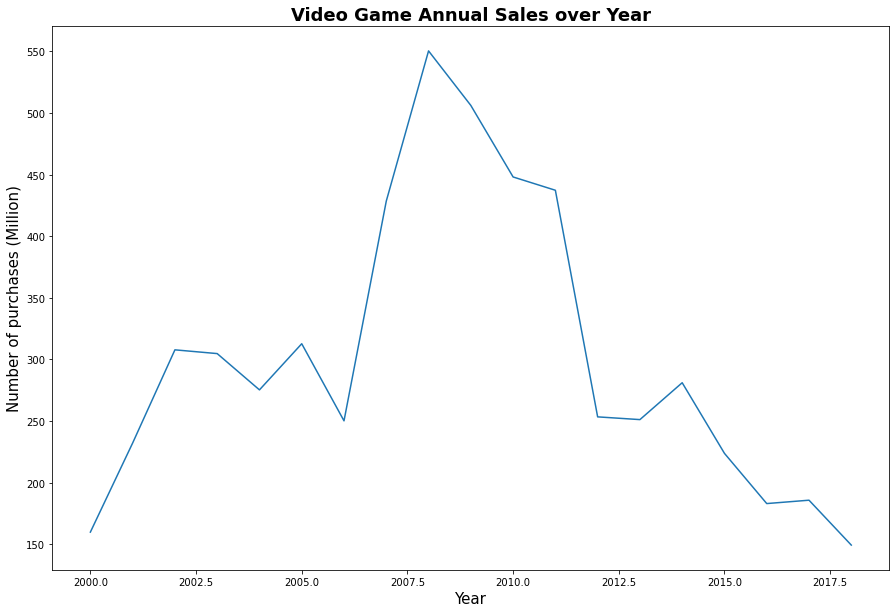

In [16]:
import matplotlib.pyplot as plt
graph_df1 = df.copy(deep=True)

# Trim the data
graph_df1 = graph_df1[graph_df1["Year"] >= 2000]
graph_df1 = graph_df1[graph_df1["Year"] <= 2018]

fig, ax = plt.subplots(figsize=(15,10))
# Group the data by Year, and plot the sum of Global_Sales at that year.
graph_df1.groupby(["Year"]).sum()["Global_Sales"].plot(ax=ax)
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Number of purchases (Million)", fontsize = 15)
plt.title("Video Game Annual Sales over Year", fontweight = "bold", fontsize = 18)
plt.savefig("images/plot1.png")

<img src="images/plot1.png">

Interpretation: The graph we get is a bit unexpected. In our previous prediction, the graph would have a number of
purchases gradually increase as the year goes, which means as time goes, more games are purchased by people,
However, as viewed on the graph, the number dramatically decreased after 2011. This is not a reasonable result to accept,
 hence, we need some explanation on what might happen that caused this result. There are some possible causes for this problem.
 The dataset may not collect enough game sale data after 2011 since there are more and more video games appear on the market.
 During the data processing phase, we notice that the dataset failed to record lots of sale data of video games.
 It has nans on some entries of the Global Sales, NA sales and also data from other regions. As a result,
 when we clean the data and drop some of those rows with nans, some video game purchases were also lost in the process.

 After looking at the global annual video game sales over years,
  Therefore, let's plot the top 50 global best-selling games in some years to visualize how video game sales distribute in a year.
  We choose data in year of 2016, 2017 and 2018, and plot them in three separate graphs.

In [17]:
graph_df2 = df[df["Year"] == 2016].copy(deep = True)
# Sort values by Global_Sales
graph_df2 = graph_df2.sort_values(by = "Global_Sales", ascending = False)
graph_df2 = graph_df2.reset_index(drop = True)
# Keep first 50 data
graph_df2 = graph_df2.head(50)
graph_df2["Rank"] = np.arange(1,51)

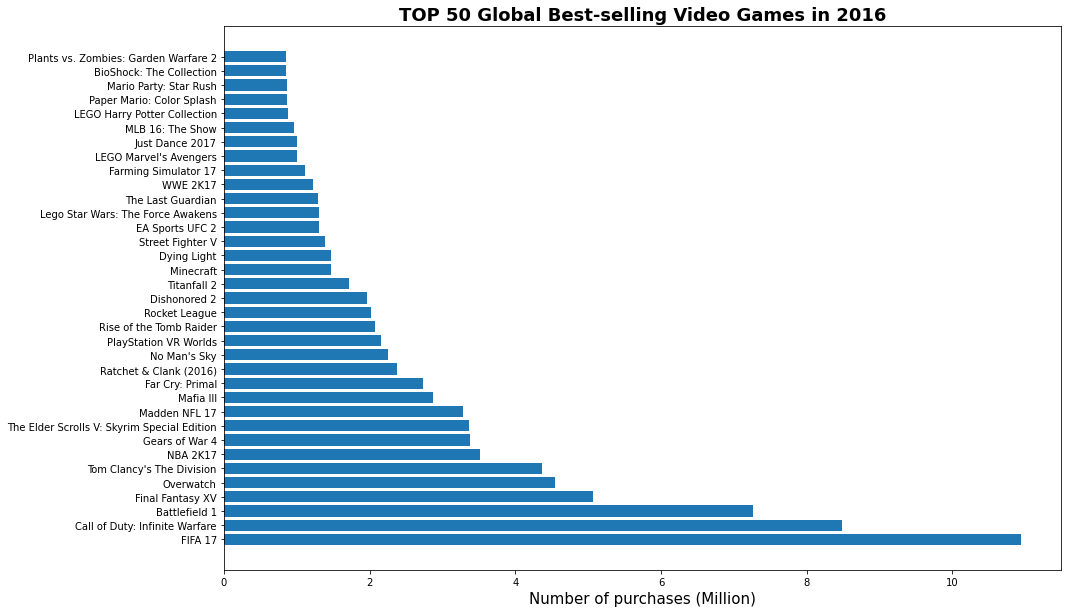

In [18]:
# Create a horizontal bar plot
fig = plt.figure(figsize = (15, 10))
plt.barh(graph_df2["Name"], graph_df2["Global_Sales"])
plt.xlabel("Number of purchases (Million)", fontsize = 15)
plt.title("TOP 50 Global Best-selling Video Games in 2016", fontweight = "bold", fontsize = 18)
plt.savefig("images/plot2.png")

<img src="images/plot2.png">

In [19]:
graph_df2 = df[df["Year"] == 2017].copy(deep = True)
graph_df2 = graph_df2.sort_values(by = "Global_Sales", ascending = False)
graph_df2 = graph_df2.reset_index(drop = True)
graph_df2 = graph_df2.head(50)
graph_df2["Rank"] = np.arange(1,51)

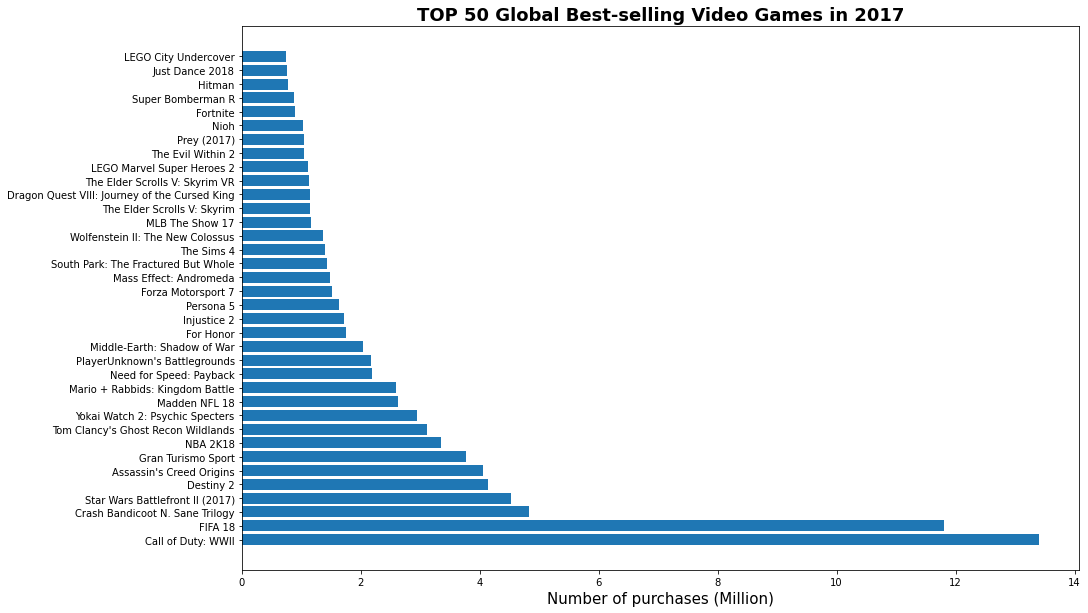

In [20]:
fig = plt.figure(figsize = (15, 10))
plt.barh(graph_df2["Name"], graph_df2["Global_Sales"])
plt.xlabel("Number of purchases (Million)", fontsize = 15)
plt.title("TOP 50 Global Best-selling Video Games in 2017", fontweight = "bold", fontsize = 18)
plt.savefig("images/plot3.png")

<img src="images/plot3.png">

In [21]:
graph_df2 = df[df["Year"] == 2018].copy(deep = True)
graph_df2 = graph_df2.sort_values(by = "Global_Sales", ascending = False)
graph_df2 = graph_df2.reset_index(drop = True)
graph_df2 = graph_df2.head(50)
graph_df2["Rank"] = np.arange(1,51)

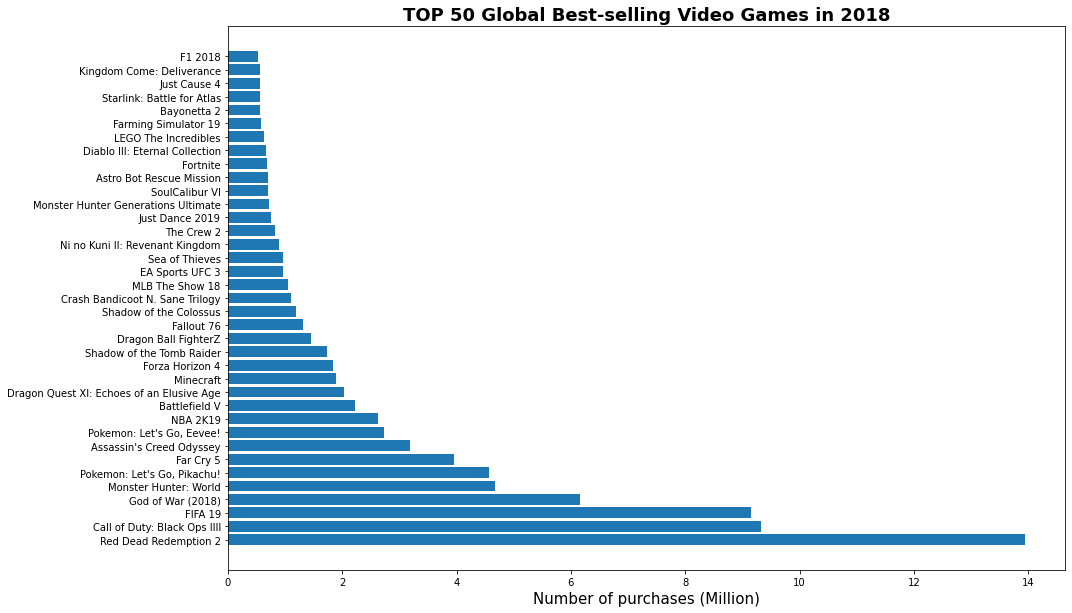

In [22]:
fig = plt.figure(figsize = (15, 10))
plt.barh(graph_df2["Name"], graph_df2["Global_Sales"])
plt.xlabel("Number of purchases (Million)", fontsize = 15)
plt.title("TOP 50 Global Best-selling Video Games in 2018", fontweight = "bold", fontsize = 18)
plt.savefig("images/plot4.png")

<img src="images/plot4.png">

From the graph, we see that the most best-selling video game in 2016 was "FIFA 17", in 2017 was "Call of Duty: WWII", and in the year 2018 was "Red Dead Redemption", followed by "Call of Duty: Black Ops III" and "FIFA 19". Comparing the three plots, we can discover a pattern. It seems that each year, there are a few games that are very successful and receive really high amount of sales. And as rank goes down, the sale will quickly drop at first, and then remain at a relatively mild decreasing slope after the top 15 games.

From the dataset, we also noticed that those games are categorized by different genres. Consequently, we want to find out how different genres are distributed among all video games.

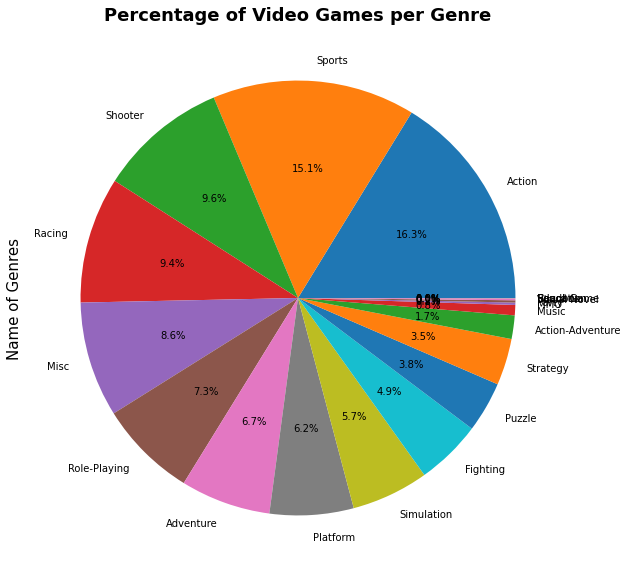

In [23]:
graph_df3 = df.copy(deep=True)
fig, ax = plt.subplots(figsize=(15,10))
# Group the data by geners and count all games appeared within those genres.
temp = graph_df3.groupby(["Genre"]).count()["Name"]
temp.sort_values(ascending = False).plot(kind = "pie", ax=ax, autopct = '%1.1f%%')
plt.ylabel("Name of Genres", fontsize = 15)
plt.title("Percentage of Video Games per Genre", fontweight = "bold", fontsize = 18)
plt.savefig("images/plot5.png")

<img src="images/plot5.png">

As we observe from the pie chart above, among all video game genres, Action, Sports, Shooter, and Racing video games occupied a great amount of the video game industry (50.4%). It's reasonable to say that those four categories of games have a relatively larger group of customers and popularity among all genres. If a developer wants to start a new game project, these 4 genres are good choices to pick.

Now we want to acquire a general idea of how these popularities of different genres change over the year, i.e. the trends of different video game genres as time goes. We set the time period from 1990 to 2018 and plot the graph.

In [24]:
# Define the range of yuear wo want
start_year = 1990
end_year = 2018
graph_df4 = df.copy(deep=True)
graph_df4 = graph_df4[graph_df4["Year"] >= start_year]
graph_df4 = graph_df4[graph_df4["Year"] <= end_year].reset_index(drop = True)

# Define a dataframe with year as columns and genre as rows, and set all counts to zero
graph4 = pd.DataFrame(index = graph_df4["Genre"].unique(), columns = range(start_year, end_year+1))
graph4 = graph4.fillna(value = 0)

# Counting all games and update corresponding cells
for i in range(0,len(graph_df4)):
    graph4.loc[graph_df4.iloc[i].Genre, graph_df4.iloc[i].Year] = graph4.loc[graph_df4.iloc[i].Genre, graph_df4.iloc[i].Year] + 1

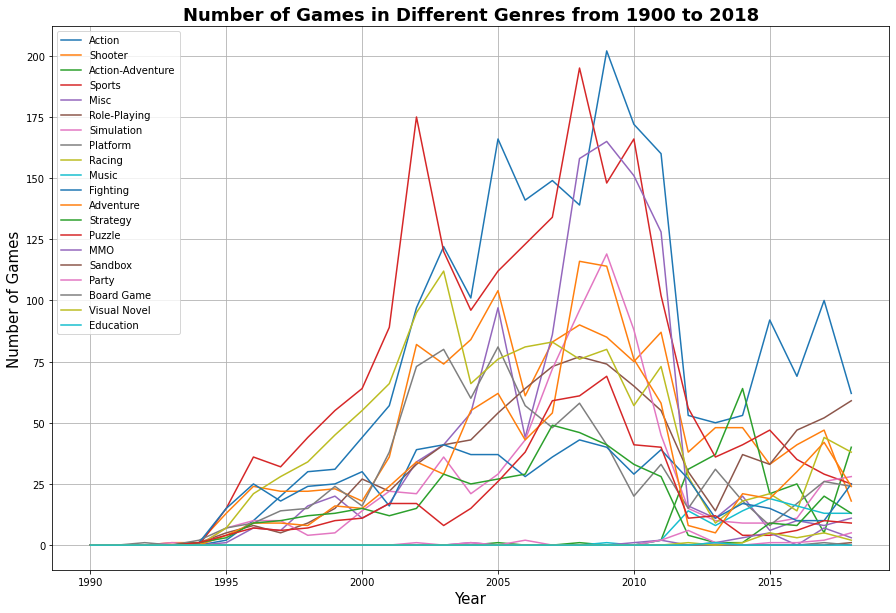

In [25]:
graph4.T.plot(grid = True, figsize=(15,10))
plt.title("Number of Games in Different Genres from 1900 to 2018", fontweight = "bold", fontsize = 18)
plt.ylabel("Number of Games", fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.savefig("images/plot6.png")

<img src="images/plot6.png">

Let's further specify the graph and look at the trends of the 5 most popular genres, among all of the genres.

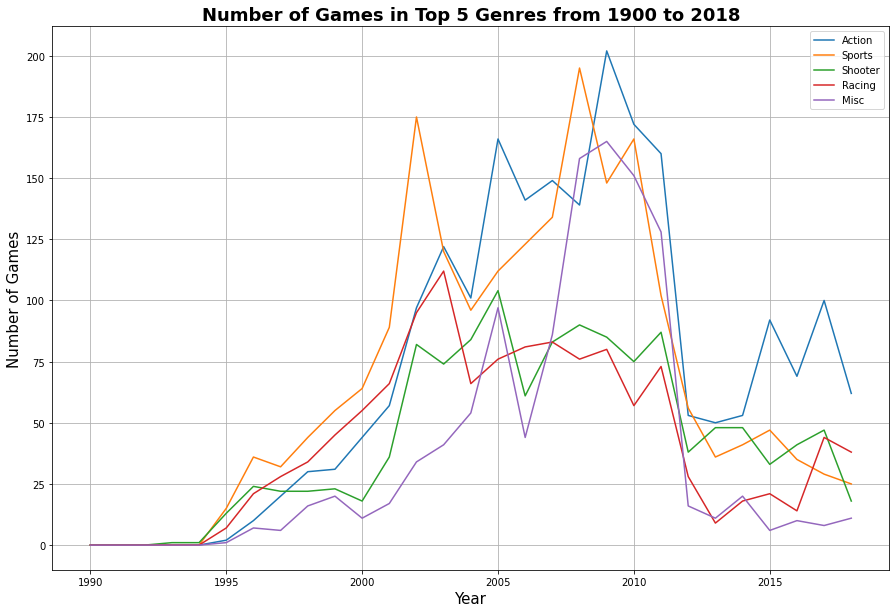

In [26]:
graph4a = pd.DataFrame()
graph4a["Action"] = graph4.loc["Action"]
graph4a["Sports"] = graph4.loc["Sports"]
graph4a["Shooter"] = graph4.loc["Shooter"]
graph4a["Racing"] = graph4.loc["Racing"]
graph4a["Misc"] = graph4.loc["Misc"]
graph4a = graph4a.transpose()
graph4a.T.plot(grid = True, figsize=(15,10))
plt.title("Number of Games in Top 5 Genres from 1900 to 2018", fontweight = "bold", fontsize = 18)
plt.ylabel("Number of Games", fontsize = 15)
plt.xlabel("Year", fontsize = 15)
plt.savefig("images/plot7.png")

<img src="images/plot7.png">

Interpretation:
 - Shape of the graph: We see from the major left part of the graph that games in those genres have grown a lot since 1990, especially for the top 5 genres, which are growing almost at exponential. Most of the other genres experienced a linear growth, and a few unpopular genres have very limited growth.
 - Further on dataset issues discussed above: From the dataset, we obtain the graphs that have similar shapes to the first graph (Global Sales vs. Year). However, this time we are not adding up sales, but just counting numbers of games instead. Both plots have sharp decrement after 2010, therefore, it's reasonable to identify that there are a large amount of video game sale data not collected after 2010.

Also, our global sales amount was contributed by sales in 4 regions: NA, PAL, JP, and others. North America is a large market that all video game developers will definitely consider. Therefore, we want to learn whether or not video game sales in North American have a positive correlation with sales in the global market. Below you will see a scatter plot about North America Sales versus Global Sales.

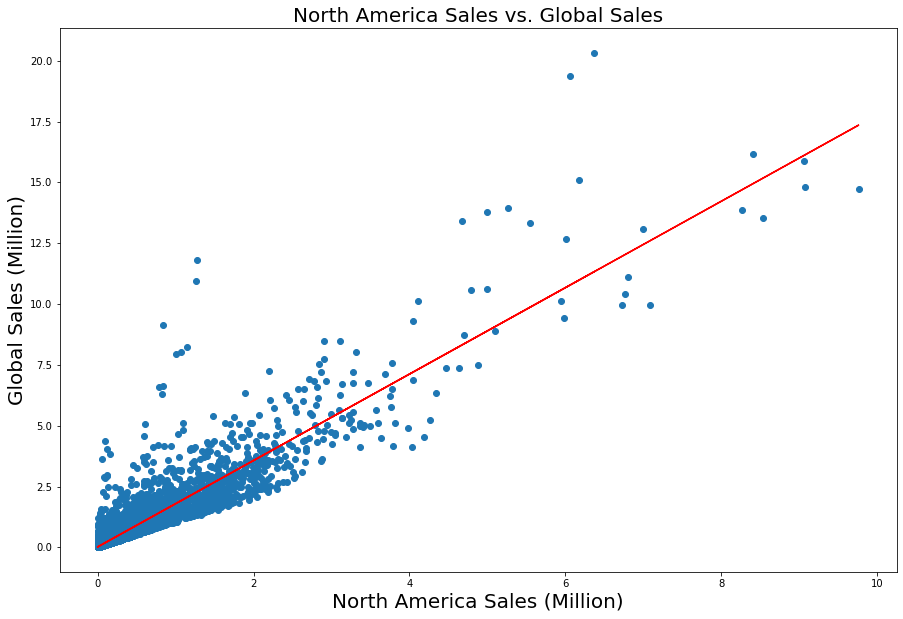

In [27]:
graph_df5 = df.copy(deep=True)
graph_df5 = graph_df5[graph_df5["NA_Sales"].notna()]

plt.figure(figsize = (15,10))
x = graph_df5["NA_Sales"]
y = graph_df5["Global_Sales"]
plt.scatter(x, y)
plt.title("North America Sales vs. Global Sales", fontsize = 20)
plt.xlabel("North America Sales (Million)", fontsize = 20)
plt.ylabel("Global Sales (Million)", fontsize = 20)
fit = np.polyfit(x = x, y = y, deg = 1)
plt.plot(x, fit[0] * x + fit[1], color="red")
plt.savefig("images/plot8.png")

<img src="images/plot8.png">

From the graph, we see lots of data points are located at the lower-left corner. This is because we set the sale amount in millions, and many video games in the industry do not have sales large enough. We discover that there exists a positive correlation between North America Sales and Global Sales. This indicates that the increment or decrement of video game sales in North America may lead to similar movements in global markets. And there is a form of dependence between the global market and the North American market, so the data collected in NA could also be used in the prediction of the global market.

## 5. Machine Learning Model <a name="ml-model"></a>
In this section, we are going to implement several models and predict global sales. In the world of machine learning, people
can split datas into two groups: numerical data and categorical data. Numerical data is everything that represented by numbers (integer
and floating point). It's continuous. Categorical data, however, is discrete. Different models will be used to predict these two type of data.

### 5.a What and Why <a name="what-why"></a>

We want to use *multiple linear regression* for predicting numerical sale number. The reason is that we intend to investigate
how strong the relationship is between many independent variables (in this case, critic score, developers and other variables) and
one dependent variable -- sale score. We made several assumptions for using multiple linear regression.
 - Homogeneity of Variance: the size of the error in our prediction doesn't change a lot
 - Independence of Observations: each game is independent of others.
 - Linearity: the line of best fit through the data point is a straight line.

Several models will be used for the prediction of categorical sale number: *Random forest*, *k-nearest neighbors* (KNN) and
*Support vector machine*(SVM)

Single decision tree suffers from a high variance, which makes them less accurate than other models. However, random forest fixes
this problem. Benefits of using random forests:
 -  Bagging and bootstrap reduce the output variance
 -  Able to handle large dataset with high dimensionality (which is our datset)

k-nearest neightbors, as one of the most famous classifications algorithm, surely have many positive sides:
 - No training period
 - Easily to add new data
 - Easy to implement

Here is the advantages of choosing support vector machine as one of our algorithem.
 -  Effective in high dimensional spaces
 -  Use a subset of training set in the decision function and, therefore, prevent overfitting
 -  Memory efficient

### 5.b Training <a name="training"></a>
**Multiple Linear Regression**

We will use sklearn library for most of our training task.

In [28]:
from sklearn import linear_model, model_selection
from sklearn.ensemble import RandomForestClassifier
import sklearn

# build model for numerical predictors
muti_linear_regression = linear_model.LinearRegression(n_jobs=-1)

Explanation:

This is a very simple and straight-forward model with n_jobs = -1, which means we want to use all available CPU cores for efficiency purpose

**Categorical Model**

In [29]:
# build model for categorical predictors
random_forest = RandomForestClassifier(n_estimators = 1000, random_state=42,max_depth=4,n_jobs = -1)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
svm = sklearn.svm.LinearSVC(max_iter=2000,dual=False)

Explanation:

To determine the number of trees (n_estimators in the function), we theoretically want as many trees as possible but the
margin of accuracy of getting more than 1000 trees become neglectable. random_state will increase the randomness when the algorithm is
bootstrapping.It is suggested that the maximum depth of the tree is sqrt(number of features), and also the
more depth of a tree, the better it perform with diminishing returns. I will just choose 4 and the benefit of more than 4 is too small. The number of jobs indicates how many
threads that are working in parallel.

As for kNN, to determine the number of neighbors, I did several experiments. It turns out that n_neightbors = 5 can generate best output. Too small n_neightbor will result in
unstable decision boundaries will too large will make the decision boundaries unclear.

SVM is little bit intriguing. There are two options for us to set the "decision_function_shape". One is "ovo", which stands for one-verses-one, and the other option is called one-vs-the-rest.
One-verse-one compare each classcifier with the predict value one by one while the one verse the rest option treats the x as a group and compare it with the y. In our case, we consider all the regressor
as a group. The reason why we set max_iter to 2000 is that it will not converge at default number of iterations

In [30]:
# Assign first several columns as X and last two columns as ground truth
X = df_for_training.iloc[:, 0:5]
y_categorical = df_for_training[['Sales_Ranking']].to_numpy().flatten()
y_numerical = df_for_training[['Global_Sales']].to_numpy().flatten()

In [31]:
# numerical model
# 10-fold cross validation for multi-linear regression:
linear_score = []
X = X.to_numpy()
for train_index, test_index in model_selection.KFold(n_splits=10).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_numerical[train_index], y_numerical[test_index]
    model = muti_linear_regression.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    linear_score.append(score)
print('The average score for linear regression is ',np.average(linear_score))
print("The standard error of the score is ", np.std(linear_score))

The average score for linear regression is  0.8424202980666509
The standard error of the score is  0.03612723687235236


In [32]:
# categorical model
# Implement 10-fold cross validation
rfr_score = model_selection.cross_val_score(random_forest, X, y_categorical, cv = 10)
print("The average score for Random Forest is ", np.average(rfr_score))
print("The standard error of the score is ", np.std(rfr_score))
knn_score = model_selection.cross_val_score(knn, X, y_categorical, cv = 10)
print("The average score for kNN is ", np.average(knn_score))
print("The standard error of the score is ", np.std(knn_score))
svm_score = model_selection.cross_val_score(svm,X, y_categorical, cv = 10)
print("The average score for SVM is ", np.average(svm_score))
print("The standard error of the score is ", np.std(svm_score))

The average score for Random Forest is  0.9442180422503478
The standard error of the score is  0.004712117958993125
The average score for kNN is  0.8733701605948303
The standard error of the score is  0.003909255185019338
The average score for SVM is  0.8972463464093421
The standard error of the score is  0.016865616208509227


### 5.c Result Anlysis and Demonstration <a name="result-and-demon"></a>
Below is the bar graph of accuracy score for different models.

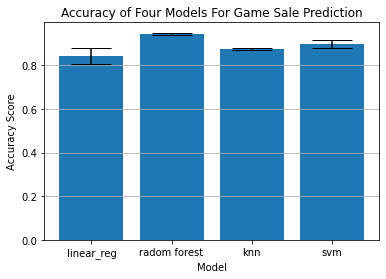

In [33]:
import matplotlib.pyplot as plt
models = ['linear_reg', 'radom forest', 'knn', 'svm']
scores = [linear_score,rfr_score, knn_score,svm_score]
accuracy = np.average(scores,axis=1)
std = np.std(scores,axis=1)
fig, ax = plt.subplots()
ax.bar(models,accuracy,align = 'center',yerr = std, capsize=20)
ax.set_xticks(models)
ax.set_title('Accuracy of Four Models For Game Sale Prediction')
ax.yaxis.grid(True)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy Score')
plt.savefig("images/plot9.png")

<img src="images/plot8.png">
Random forest model has the best accuracy score and I think bagging and bootstrap could be the reason why it outperformed other models.
Also, the prediction for categorical variable generally better than the numerical prediction becuase, intuitively, predicting a category is
easier than a specific number.

Since we are interested in the difference between two variables for the same subject, we are going to perform paired-t test for the predicted value and the ground truth to see
the statistical difference between them. Our null hypothesis would be the average difference between the predicted value and ground truth is 0 and alternative hypothesis is the
average difference is not 0. We choose alpha value = 0.05

In [34]:
from scipy import stats
muti_linear_regression.fit(X,y_categorical)
pred_y = muti_linear_regression.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for  multi-linear regression has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for  multi-linear regression has the following result
test statistics = -0.0 
p value = 1.0


In [35]:
random_forest.fit(X,y_categorical)
pred_y = random_forest.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for random forest  has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for random forest  has the following result
test statistics = 7.807 
p value = 0.0


In [36]:
knn.fit(X,y_categorical)
pred_y = knn.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for k-nearest neightbor has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for k-nearest neightbor has the following result
test statistics = 22.912 
p value = 0.0


In [37]:
svm.fit(X,y_categorical)
pred_y = svm.predict(X)
(statistics, pvalue) = stats.ttest_rel(y_categorical, pred_y)
print("paired t-test for support vector machine has the following result")
print(f'test statistics = {np.round(statistics,3)} \np value = {np.round(pvalue,3)}')

paired t-test for support vector machine has the following result
test statistics = 38.561 
p value = 0.0


From above result, it is interesting to see that we failed reject null hypothesis (i.e. there is no difference between
the predicted value and ground truth for multi-linear regression paired-t test) but reject the null hypothesis (that is, there IS a difference)
for the rest of three paired-t test. However, according to the accuracy score, random forest model achieved the highest. Why does this happen?

According the formula that calculate t-value, we need to find the standard deviation of the difference between two groups. This standard deviation doesn't
make sense when it comes to category. You can think it as using l2 loss (mean squared error) instead of cross-entropy loss for categorical problem. Therefore,
we'd better directly use accuracy score for model-model comparison.

## 6. Future Application <a name="future-app"></a>
Given the accuracy of 4 models, we recommend to predict future games with random forest model. Suppose you have a new game
 with input data called new_game. You can predict its sale with the following command:
```
random_forest.predict(X = new_game)
```
The result will be a number and the smaller the number is, the more it will be sold. Also, if you really hope to get a
specific number, you can run this line:
```
muti_linear_regression.predict(new_game)
```
It will provide you a estimated sale number. Please don't feel frustrated if the predicted value is zero. Remember, the
sale prediction is in million. If you are a independent game developer, selling a couple of thousand of game is great!

## 7. Reference and External Link <a name="ref-and-extlink"></a>
#### Gaming industry statistics
 - https://www.statista.com/statistics/292056/video-game-market-value-worldwide/
 - https://www.statista.com/statistics/552623/number-games-released-steam/

#### Want to to know more about multiple linear regression?
 - https://www.scribbr.com/statistics/multiple-linear-regression/
 - https://en.wikipedia.org/wiki/Linear_regression
 - https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e

#### Extend materials for support vector machine, Knn, random forest
 - https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
 - https://www.youtube.com/watch?v=1NxnPkZM9bc
 - https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
 - https://scikit-learn.org/stable/modules/svm.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### paired-t test reading:
 - https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/SAS/SAS4-OneSampleTtest/SAS4-OneSampleTtest7.html